In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import blackjack as bj
from blackjack import Hand, HandScore, Action, make_hand
import simulator as sim
import optimizer as opt


In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False, drawn=False, surrendered=False)

In [10]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False, drawn=False, surrendered=False)

In [11]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False, drawn=False, surrendered=False)

In [12]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False, drawn=False, surrendered=False),
 True)

In [13]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False, drawn=False, surrendered=False)

In [14]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=s12, cards=[1, 1], doubled=False, drawn=False, surrendered=False)

In [15]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h12, cards=[1, 1, 11], doubled=False, drawn=False, surrendered=False)

In [16]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False, drawn=False, surrendered=False),
 True)

## Now define gameplay and strategy

In [17]:
shoe = bj.Shoe()
[shoe.deal() for _ in range(10)]

[6, 7, 10, 6, 1, 8, 13, 13, 5, 6]

In [18]:
bj.play_one_round([bj.strat_nobust, bj.strat_nobust])

[('strat_nobust_func',
  Hand(score=h14, cards=[8, 2, 4], doubled=False, drawn=True, surrendered=False),
  Hand(score=h22, cards=[10, 4, 8], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.WIN: 1>),
 ('strat_nobust_func',
  Hand(score=h20, cards=[8, 2, 13], doubled=False, drawn=True, surrendered=False),
  Hand(score=h22, cards=[10, 4, 8], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.WIN: 1>)]

## Aggregate and summarize the data from the simulations

In [19]:


strat_nobust = bj.strat_nobust
strat_dealer = bj.strat_dealer
sim.generate_rows_from_round(bj.play_one_round([bj.strat_nobust, bj.strat_dealer]))


[{'strategy': 'strat_nobust_func',
  'hand_start': [7, 7],
  'dealer_card': 3,
  'hand_end': [7, 7],
  'dealer_hand': [3, 4, 9, 6],
  'outcome': <HandOutcome.WIN: 1>},
 {'strategy': 'strat_dealer_func',
  'hand_start': [7, 7],
  'dealer_card': 3,
  'hand_end': [7, 7, 2, 9],
  'dealer_hand': [3, 4, 9, 6],
  'outcome': <HandOutcome.LOSE: -1>}]

In [20]:


sim_results = sim.run_n_sim_trials([strat_nobust, strat_dealer], 10000)
#%prun -s cumulative sim_results, sim.summarize_totals(sim_results)

In [21]:
def strat_simple_func(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple_func.name = 'simple'

strat_simple = bj.Strategy_wrapper(strat_simple_func)
sims = sim.run_n_sim_trials([strat_simple], 1000)
sims.head(10), sim.summarize_totals(sims)

(            strategy hand_start  dealer_card          hand_end  \
 0  strat_simple_func    [6, 12]            9        [6, 12, 1]   
 1  strat_simple_func     [7, 4]            3         [7, 4, 8]   
 2  strat_simple_func     [6, 4]            2        [6, 4, 12]   
 3  strat_simple_func     [3, 2]            1  [3, 2, 1, 10, 4]   
 4  strat_simple_func     [5, 1]           11   [5, 1, 3, 6, 6]   
 5  strat_simple_func     [5, 1]           12   [5, 1, 6, 1, 6]   
 6  strat_simple_func     [2, 5]           11     [2, 5, 5, 13]   
 7  strat_simple_func    [8, 12]            8           [8, 12]   
 8  strat_simple_func     [6, 3]            2      [6, 3, 7, 2]   
 9  strat_simple_func    [13, 7]           13           [13, 7]   
 
        dealer_hand                 outcome  outcome_value outcome_name  
 0        [9, 6, 7]         HandOutcome.WIN            1.0          WIN  
 1  [3, 3, 4, 5, 7]  HandOutcome.WIN_DOUBLE            2.0   WIN_DOUBLE  
 2       [2, 13, 9]        HandOutcome.

In [22]:
%prun -s cumulative sim.summarize_totals(sim.run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


## Simulate specific situations to determine strategy

In [23]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False, drawn=False, surrendered=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False, surrendered=False))

In [24]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]


    
strat_cond = sim.generate_strat_conditional(strat_simple, conditions)
strat_cond

strat_cond

In [25]:
# Generate a conditional strategy for each action
    
strats = sim.gen_cond_strategies(strat_simple, cond_12_2, Action)
strats

[<Action.SURRENDER: 1>, <Action.STAND: 2>, <Action.HIT: 3>, <Action.DOUBLE: 4>]

In [26]:
bj.complete_one_round(strats, hand_p, hand_d, bj.Shoe().deal(), bj.Shoe())

[('<Action.SURRENDER: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False, drawn=False, surrendered=True),
  Hand(score=h20, cards=[2, 5, 3, 10], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.SURRENDER: -0.5>),
 ('<Action.STAND: 2>',
  Hand(score=h12, cards=[5, 7], doubled=False, drawn=False, surrendered=False),
  Hand(score=h20, cards=[2, 5, 3, 10], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.LOSE: -1>),
 ('<Action.HIT: 3>',
  Hand(score=h18, cards=[5, 7, 6], doubled=False, drawn=True, surrendered=False),
  Hand(score=h20, cards=[2, 5, 3, 10], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.LOSE: -1>),
 ('<Action.DOUBLE: 4>',
  Hand(score=h17, cards=[5, 7, 5], doubled=True, drawn=True, surrendered=False),
  Hand(score=h20, cards=[2, 5, 3, 10], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.LOSE_DOUBLE: -2>)]

In [27]:


sims = sim.run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        5970  521         0     0       3509   
<Action.HIT: 3>        6041           0  654         0  3305          0   
<Action.STAND: 2>      6426           0    0         0  3574          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>         -0.4922  
<Action.HIT: 3>            -0.2736  
<Action.STAND: 2>          -0.2852  
<Action.SURRENDER: 1>      -0.5000

In [28]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=s12, cards=[1, 1], doubled=False, drawn=False, surrendered=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False, surrendered=False))

In [29]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = sim.gen_cond_strategies(strat_simple, cond_12s_2, Action)
strats

[<Action.SURRENDER: 1>, <Action.STAND: 2>, <Action.HIT: 3>, <Action.DOUBLE: 4>]

In [30]:
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        6403    0         0     0       3597   
<Action.HIT: 3>        5255           0  827         0  3918          0   
<Action.STAND: 2>      6403           0    0         0  3597          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   
strat_simple_func      5249           0  840         0  3911          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>         -0.5612  
<Action.HIT: 3>            -0.1337  
<Action.STAND: 2>          -0.2806  
<Action.SURRENDER: 1>      -0.5000  
strat_simple_func          -0.1338

In [31]:
sim.summarize_totals(sim.run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 10*1000))

len            mean_outcome
outcome_name       LOSE PUSH   WIN             
strategy                                       
strat_cond         6388    0  3612      -0.2776
strat_simple_func  6051  668  3281      -0.2770

In [32]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = sim.gen_cond_strategies(strat_simple, cond_13s_6, Action)
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 10000)
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        5791    0         0     0       4209   
<Action.HIT: 3>        4902           0  299         0  4799          0   
<Action.STAND: 2>      5791           0    0         0  4209          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   
strat_simple_func      5791           0    0         0  4209          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>         -0.3164  
<Action.HIT: 3>            -0.0103  
<Action.STAND: 2>          -0.1582  
<Action.SURRENDER: 1>      -0.5000  
strat_simple_func          -0.1582

In [33]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = sim.gen_cond_strategies(strat_simple, cond_10_6, Action)
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        3164  698         0     0       6138   
<Action.HIT: 3>        3239           0  708         0  6053          0   
<Action.STAND: 2>      5776           0    0         0  4224          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   
strat_simple_func      3191           0  682         0  6127          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>          0.5948  
<Action.HIT: 3>             0.2814  
<Action.STAND: 2>          -0.1552  
<Action.SURRENDER: 1>      -0.5000  
strat_simple_func           0.2936

In [34]:
sim.test_cond(HandScore(10), HandScore(6), 10000, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                         len                                              \
 outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
 strategy                                                                  
 <Action.DOUBLE: 4>        0        3212  659         0     0       6129   
 <Action.HIT: 3>        3161           0  676         0  6163          0   
 <Action.STAND: 2>      5704           0    0         0  4296          0   
 <Action.SURRENDER: 1>     0           0    0     10000     0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>          0.5834  
 <Action.HIT: 3>             0.3002  
 <Action.STAND: 2>          -0.1408  
 <Action.SURRENDER: 1>      -0.5000  )

In [35]:
sim.test_cond(HandScore(18), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                        len                                            \
 outcome_name          LOSE LOSE_DOUBLE PUSH SURRENDER WIN WIN_DOUBLE   
 strategy                                                               
 <Action.DOUBLE: 4>       0         159    7         0   0         34   
 <Action.HIT: 3>        162           0    5         0  33          0   
 <Action.STAND: 2>       72           0   29         0  99          0   
 <Action.SURRENDER: 1>    0           0    0       200   0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>          -1.250  
 <Action.HIT: 3>             -0.645  
 <Action.STAND: 2>            0.135  
 <Action.SURRENDER: 1>       -0.500  )

In [36]:
sim.test_cond(HandScore(21, True), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                             len                                        \
 outcome_name          BLACKJACK LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE   
 strategy                                                                
 <Action.DOUBLE: 4>            0    0          74   13    0        113   
 <Action.HIT: 3>               0   58           0   15  127          0   
 <Action.STAND: 2>           200    0           0    0    0          0   
 <Action.SURRENDER: 1>       200    0           0    0    0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>           0.390  
 <Action.HIT: 3>              0.345  
 <Action.STAND: 2>            1.500  
 <Action.SURRENDER: 1>        1.500  )

In [37]:

sim.find_winning_action(HandScore(10), HandScore(6), 200)

{'<Action.DOUBLE: 4>': 0.81,
 '<Action.HIT: 3>': 0.445,
 '<Action.STAND: 2>': -0.04,
 '<Action.SURRENDER: 1>': -0.5,
 'score_p': 'h10',
 'score_d': 'h06',
 'winning_act': <Action.DOUBLE: 4>,
 'winning_act_outcome': 0.81}

In [38]:
sim.test_cond(HandScore(18), HandScore(11, True), 1000)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                        len                                             \
 outcome_name          LOSE LOSE_DOUBLE PUSH SURRENDER  WIN WIN_DOUBLE   
 strategy                                                                
 <Action.DOUBLE: 4>       0         874   18         0    0        108   
 <Action.HIT: 3>        854           0   30         0  116          0   
 <Action.STAND: 2>      614           0  113         0  273          0   
 <Action.SURRENDER: 1>  331           0    0       669    0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>         -1.5320  
 <Action.HIT: 3>            -0.7380  
 <Action.STAND: 2>          -0.3410  
 <Action.SURRENDER: 1>      -0.6655  )

In [39]:
%prun -s cumulative conds = sim.compute_instructions(20)
pd.DataFrame(conds).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 4>  <Action.HIT: 3>  <Action.STAND: 2>  \
score_p score_d                                                           
h09     s11                    -1.1            -0.60              -0.70   
        h02                    -0.6             0.30              -0.70   
        h03                     0.2            -0.05              -0.20   
        h04                     0.6             0.35              -0.30   
        h05                     0.4             0.40              -0.20   
...                             ...              ...                ...   
s21     h06                     0.8             0.70               1.50   
        h07                    -0.2             0.10               1.50   
        h08                     0.3             0.15               1.50   
        h09                    -0.1             0.15               1.50   
        h10                    -0.1             0.00               1.35   

                 <Action.SURRENDER: 1>    winning_act  winning_act_outcome  
score_p score_d                                                             
h09     s11                     -0.775     Action.HIT                -0.60  
        h02                     -0.500     Action.HIT                 0.30  
        h03                     -0.500  Action.DOUBLE                 0.20  
        h04                     -0.500  Action.DOUBLE                 0.60  
        h05                     -0.500  Action.DOUBLE                 0.40  
...                                ...            ...                  ...  
s21     h06                      1.500   Action.STAND                 1.50  
        h07                      1.500   Action.STAND                 1.50  
        h08                      1.500   Action.STAND                 1.50  
        h09                      1.500   Action.STAND                 1.50  
        h10                      1.350   Action.STAND                 1.35  

[250 rows x 6 columns]

In [40]:

%prun -s cumulative sim.compute_instructions(100, strat_simple)

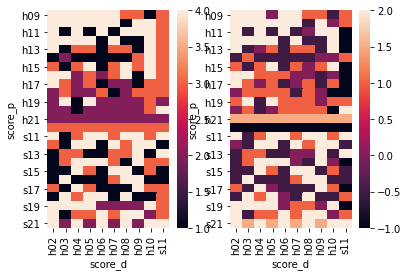

In [41]:


%prun -s cumulative opt.run_iteration(1, strat_simple, None)

In [42]:
# Memoized strategy
# Rather than generic conditions, just use an array indexed on player and dealer scores
# Since that's how we're generating our strategy anyway (one square at a time)

instructions = {(repr(HandScore(13, True)), repr(HandScore(6))): Action.HIT}
strat_memoized = opt.gen_strat_memoized(instructions, strat_simple)

sims = sim.run_n_sim_trials([strat_simple, strat_memoized], 1000)
sims.head(10), sim.summarize_totals(sims)

(            strategy hand_start  dealer_card     hand_end    dealer_hand  \
 0  strat_simple_func    [13, 1]            2      [13, 1]   [2, 7, 5, 4]   
 1           memoized    [13, 1]            2      [13, 1]   [2, 7, 5, 4]   
 2  strat_simple_func    [3, 12]            8   [3, 12, 9]        [8, 13]   
 3           memoized    [3, 12]            8  [3, 12, 13]        [8, 13]   
 4  strat_simple_func     [7, 3]            3    [7, 3, 4]  [3, 2, 3, 13]   
 5           memoized     [7, 3]            3    [7, 3, 9]  [3, 2, 3, 13]   
 6  strat_simple_func     [1, 8]           10       [1, 8]     [10, 3, 9]   
 7           memoized     [1, 8]           10       [1, 8]     [10, 3, 9]   
 8  strat_simple_func    [9, 12]            7      [9, 12]  [7, 3, 5, 13]   
 9           memoized    [9, 12]            7      [9, 12]  [7, 3, 5, 13]   
 
                  outcome  outcome_value outcome_name  
 0  HandOutcome.BLACKJACK            1.5    BLACKJACK  
 1  HandOutcome.BLACKJACK            1.

Starting iteration 0
Starting iteration 1
('h09', 'h04') Action.HIT Action.DOUBLE
('h09', 'h05') Action.HIT Action.DOUBLE
('h10', 'h02') Action.HIT Action.DOUBLE
('h10', 'h10') Action.HIT Action.DOUBLE
('h11', 'h07') Action.DOUBLE Action.HIT
('h11', 'h09') Action.DOUBLE Action.HIT
('h12', 'h02') Action.STAND Action.DOUBLE
('h12', 'h04') Action.STAND Action.DOUBLE
('h12', 'h06') Action.DOUBLE Action.STAND
('h13', 'h03') Action.STAND Action.HIT
('h13', 'h04') Action.HIT Action.DOUBLE
('h13', 'h06') Action.STAND Action.HIT
('h14', 'h08') Action.HIT Action.SURRENDER
('h14', 'h10') Action.STAND Action.HIT
('h15', 's11') Action.STAND Action.HIT
('h15', 'h06') Action.STAND Action.HIT
('h15', 'h09') Action.STAND Action.SURRENDER
('h16', 's11') Action.SURRENDER Action.STAND
('h16', 'h07') Action.HIT Action.STAND
('h16', 'h08') Action.HIT Action.SURRENDER
('h16', 'h09') Action.SURRENDER Action.STAND
('h16', 'h10') Action.HIT Action.SURRENDER
('h17', 's11') Action.STAND Action.SURRENDER
('h17', '

[strat_simple_func,
 iter(1),
 iter(2),
 iter(3),
 iter(4),
 iter(5),
 iter(6),
 iter(7),
 iter(8),
 iter(9),
 iter(10)]

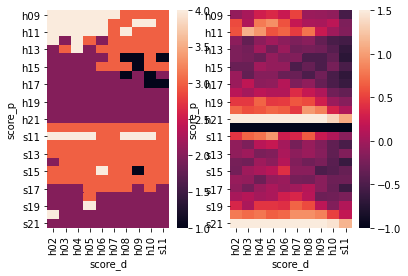

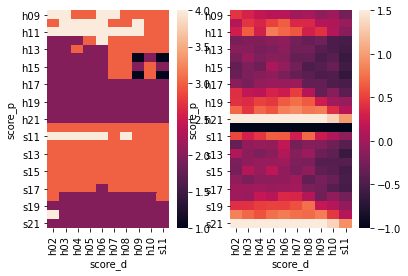

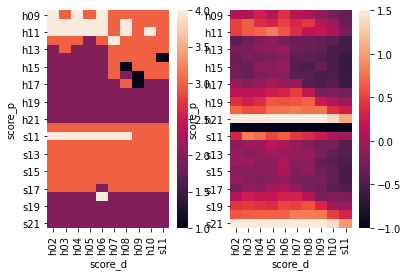

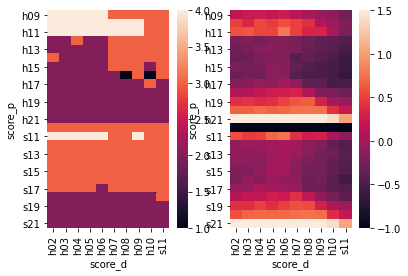

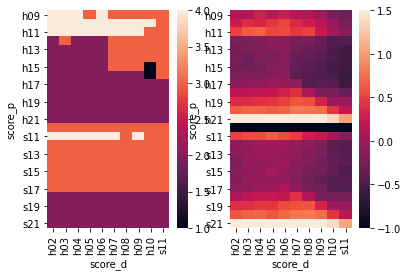

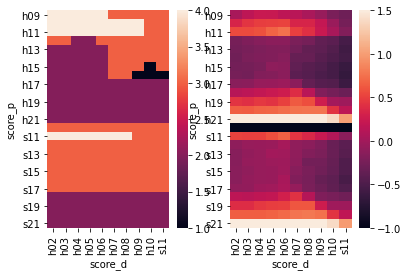

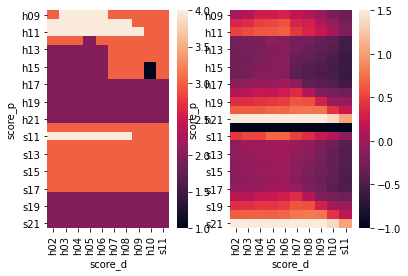

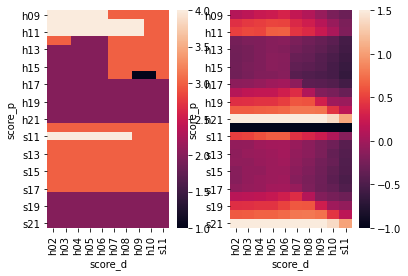

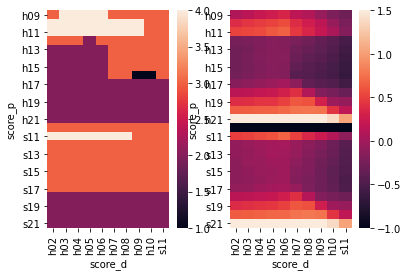

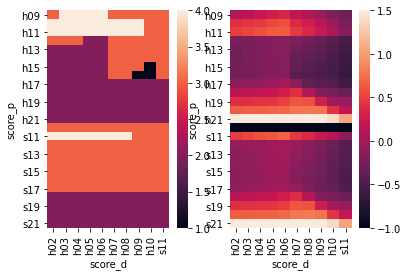

In [43]:


strategies = opt.derive_iterative_strategies(strat_simple, 10)
strategies

In [44]:
with open('strategies.pickle', 'wb') as handle:
    pickle.dump(strategies, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
sims = sim.run_n_sim_trials(strategies, 1000*1000)
sims.head(10), sim.summarize_totals(sims)

(            strategy hand_start  dealer_card     hand_end    dealer_hand  \
 0  strat_simple_func    [5, 11]            9   [5, 11, 7]  [9, 2, 1, 12]   
 1            iter(1)    [5, 11]            9      [5, 11]  [9, 2, 1, 12]   
 2            iter(2)    [5, 11]            9      [5, 11]  [9, 2, 1, 12]   
 3            iter(3)    [5, 11]            9   [5, 11, 5]  [9, 2, 1, 12]   
 4            iter(4)    [5, 11]            9   [5, 11, 3]  [9, 2, 1, 12]   
 5            iter(5)    [5, 11]            9   [5, 11, 1]  [9, 2, 1, 12]   
 6            iter(6)    [5, 11]            9   [5, 11, 3]  [9, 2, 1, 12]   
 7            iter(7)    [5, 11]            9  [5, 11, 11]  [9, 2, 1, 12]   
 8            iter(8)    [5, 11]            9   [5, 11, 5]  [9, 2, 1, 12]   
 9            iter(9)    [5, 11]            9   [5, 11, 4]  [9, 2, 1, 12]   
 
                  outcome  outcome_value outcome_name  
 0       HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.SURRENDER           -0.